# Прогнозирование оттока клиентов

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных**

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- Таблица `contract`, информация о договорах:
  - `customerID` — ID абонента;
  - `BeginDate` — дата начала действия договора;
  - `EndDate` — дата окончания действия договора;
  - `Type` — тип оплаты: раз в год-два или ежемесячно;
  - `PaperlessBilling` — электронный расчётный лист;
  - `PaymentMethod` — тип платежа;
  - `MonthlyCharges` — расходы за месяц;
  - `TotalCharges` — общие расходы абонента.
- Таблица `personal`, персональные данные клиентов:
  - `customerID` — ID пользователя;
  - `gender` — пол;
  - `SeniorCitizen` — является ли абонент пенсионером;
  - `Partner` — есть ли у абонента супруг или супруга;
  - `Dependents` — есть ли у абонента дети.
- Таблица `internet`, информация об интернет-услугах:
  - `customerID` — ID пользователя;
  - `InternetService` — тип подключения;
  - `OnlineSecurity` — блокировка опасных сайтов;
  - `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
  - `DeviceProtection` — антивирус;
  - `TechSupport` — выделенная линия технической поддержки;
  - `StreamingTV` — стриминговое телевидение;
  - `StreamingMovies` — каталог фильмов.
- Таблица `phone`, информация об услугах телефонии:
  - `customerID` — ID пользователя;
  - `MultipleLines` — подключение телефона к нескольким линиям одновременно.


## Импорты библиотек

In [1]:
!pip install scikit-learn==1.1.3


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

from scipy.stats import (
    randint, 
    uniform
)

import sqlite3 as sq

import re

import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix

import sklearn
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_curve
)

from catboost import CatBoostClassifier

from math import ceil

import torch
import torch.nn as nn


RANDOM_STATE = 12082024

TITLE_FONTSIZE = 14
LABLE_FONTSIZE = 12
TITLE_PAD = 15
LABELE_PAD = 10

## Загрузка и обзор данных

In [3]:
connection = sq.connect('ds-plus-final.db')
cursor = connection.cursor()

In [5]:
cursor.execute(
    '''
    SELECT customerID,
           BeginDate,
           EndDate,
           Type, 
           PaperlessBilling,
           PaymentMethod,
           MonthlyCharges,
           TotalCharges
    FROM contract;
    '''
)
values_contract = cursor.fetchall()

In [6]:
cursor.execute(
    '''
    SELECT customerID,
           gender,
           SeniorCitizen,
           Partner,
           Dependents
    FROM personal;
    '''
)
values_personal = cursor.fetchall()

In [7]:
cursor.execute(
    '''
    SELECT customerID,
           InternetService,
           OnlineSecurity,
           OnlineBackup,
           DeviceProtection,
           TechSupport,
           StreamingTV,
           StreamingMovies
    FROM internet;
    '''
)
values_internet = cursor.fetchall()

In [8]:
cursor.execute(
    '''
    SELECT customerID,
           MultipleLines
    FROM phone;
    '''
)
values_phone = cursor.fetchall()

In [9]:
connection.close()

In [10]:
def get_info_df(data):
    print('Первые 5 строчек датасета:', '-' * 26, sep='\n')
    display(data.head())
    print('')
    print('Общая информация:', '-' * 17, sep='\n')
    display(data.info())
    print('')
    print('Количество явных пропусков:', '-' * 27, sep='\n')
    display(data.isna().sum())
    print('')
    print('Количество дубликатов:', data.duplicated().sum())
    print('-' * 22)

### Таблица `contract`

In [11]:
df_contract = pd.DataFrame(
    values_contract, 
    columns =[
        'customer_id', 
        'begin_date', 
        'end_date', 
        'type', 
        'paperless_billing', 
        'payment_method', 
        'monthly_charges', 
        'total_charges'
    ]
)

In [12]:
get_info_df(df_contract)

Первые 5 строчек датасета:
--------------------------


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        7043 non-null   object
 1   begin_date         7043 non-null   object
 2   end_date           7043 non-null   object
 3   type               7043 non-null   object
 4   paperless_billing  7043 non-null   object
 5   payment_method     7043 non-null   object
 6   monthly_charges    7043 non-null   object
 7   total_charges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


None


Количество явных пропусков:
---------------------------


customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64


Количество дубликатов: 0
----------------------


### Таблица `personal`

In [13]:
df_personal = pd.DataFrame(
    values_personal, 
    columns =[
        'customer_id', 
        'gender',
        'senior_citizen',
        'partner',
        'dependents'
    ]
)

In [14]:
get_info_df(df_personal)

Первые 5 строчек датасета:
--------------------------


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None


Количество явных пропусков:
---------------------------


customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


Количество дубликатов: 0
----------------------


### Таблица `internet`

In [15]:
df_internet = pd.DataFrame(
    values_internet, 
    columns =[
        'customer_id', 
        'internet_service',
        'online_security',
        'online_backup',
        'device_protection',
        'tech_support',
        'streaming_tv',
        'streaming_movies'
    ]
)

In [16]:
get_info_df(df_internet)

Первые 5 строчек датасета:
--------------------------


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Количество явных пропусков:
---------------------------


customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64


Количество дубликатов: 0
----------------------


### Таблица `phone`

In [17]:
df_phone = pd.DataFrame(
    values_phone, 
    columns =[
        'customer_id', 
        'multiple_lines'
    ]
)

In [18]:
get_info_df(df_phone)

Первые 5 строчек датасета:
--------------------------


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Количество явных пропусков:
---------------------------


customer_id       0
multiple_lines    0
dtype: int64


Количество дубликатов: 0
----------------------


### Вывод

**По разделу "Загрузка и обзор данных"**

Для прогноза оттока клиентов предоставлены 4 таблицы данных с информацией о договорах, персональных данных клиентов, интернет-услугах и услугах телефонии. 

Все таблицы содержат данные, количество таблиц соответствует условию задачи.

- Таблица `contract` состоит из 8 колонок и 7043 строк
- Таблица `personal` состоит из 5 колонок и 7043 строк
- Таблица `internet` состоит из 8 колонок и 5517 строк
- Таблица `phone` состоит из 2 колонок и 6361 строки

Все таблицы можно соединить, используя идентификатор пользователя.

Так же в полученных данных отсутствуют явные пропуски и дубликаты.

## Исследовательский анализ и предобработка данных

In [19]:
def get_unique_info(data):
    for column in data.columns:
        print(
            f'Кол-во уникальных значений {column}:',
            data[column].nunique(),
            '\n',
            data[column].unique(), 
            '\n'
        )

### Таблица `contract`

In [20]:
get_unique_info(df_contract)

Кол-во уникальных значений customer_id: 7043 
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Кол-во уникальных значений begin_date: 77 
 ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '20

Обзор уникальных значений выявил несколько моментов:
- в столбце `end_date` есть строковое значение `No`, скорее всего это означает, что действие договора еще не окончено
- значения в столбцах `monthly_charges` и `total_charges` строковые, хотя должны быть вещественные, возможно среди них присутствуют значения-аномалии

Проверим есть ли в столбце `end_date` дата `2020-02-01`, если нет - заменим значения `No` на эту дату (так как информация о договорах актуальна на 1 февраля 2020)

In [21]:
df_contract['is_active'] = 0

In [22]:
df_contract.loc[df_contract.end_date == 'No', 'is_active'] = 1

In [23]:
df_contract[df_contract.end_date == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_active


In [24]:
df_contract.loc[df_contract.end_date == 'No', 'end_date'] = '2020-02-01'

Проверим какие значения еще, помимо числовых-вещественных, присутсвуют в столбцах `monthly_charges` и `total_charges`

In [25]:
def get_wrong_values(series):
    list_wrong_values = []
    
    for value in series:
        try: 
            float(value)
        except:
            if value not in list_wrong_values:
                list_wrong_values.append(value)
                
    return list_wrong_values

In [26]:
print(
    'Значения-аномалии в monthly_charges:', 
    get_wrong_values(df_contract.monthly_charges)
)

Значения-аномалии в monthly_charges: []


In [27]:
df_contract['monthly_charges'] = df_contract['monthly_charges'].astype(float)

In [28]:
print(
    'Значения-аномалии в total_charges:', 
    get_wrong_values(df_contract.total_charges)
)

Значения-аномалии в total_charges: [' ']


In [29]:
df_contract[df_contract.total_charges == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_active
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,1
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,1
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,1
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,1
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,1
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,1
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,1
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,1
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,1
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,1


Пропущенные значения связаны с теми людьми, которые сформировали договор в последний день сбора данных (информация о договорах актуальна на 1 февраля 2020) и отсутствие числового значения скорее всего связано с отсутствием оплат. Заменим эти значения на 0.

In [30]:
df_contract.loc[df_contract.total_charges == ' ', 'total_charges'] = 0

In [31]:
df_contract['total_charges'] = df_contract['total_charges'].astype(float)

### Таблица `personal`

In [32]:
get_unique_info(df_personal)

Кол-во уникальных значений customer_id: 7043 
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Кол-во уникальных значений gender: 2 
 ['Female' 'Male'] 

Кол-во уникальных значений senior_citizen: 2 
 ['0' '1'] 

Кол-во уникальных значений partner: 2 
 ['Yes' 'No'] 

Кол-во уникальных значений dependents: 2 
 ['No' 'Yes'] 



Заменим значения `0` и `1` столбца `senior_citizen` на `No` и `Yes` как в других столбцах соответственно. Других проблемных значений не обнаружено.

In [33]:
df_personal.loc[df_personal.senior_citizen == '0', 'senior_citizen'] = 'No'

In [34]:
df_personal.loc[df_personal.senior_citizen == '1', 'senior_citizen'] = 'Yes'

### Таблица `internet`

In [35]:
get_unique_info(df_internet)

Кол-во уникальных значений customer_id: 5517 
 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Кол-во уникальных значений internet_service: 2 
 ['DSL' 'Fiber optic'] 

Кол-во уникальных значений online_security: 2 
 ['No' 'Yes'] 

Кол-во уникальных значений online_backup: 2 
 ['Yes' 'No'] 

Кол-во уникальных значений device_protection: 2 
 ['No' 'Yes'] 

Кол-во уникальных значений tech_support: 2 
 ['No' 'Yes'] 

Кол-во уникальных значений streaming_tv: 2 
 ['No' 'Yes'] 

Кол-во уникальных значений streaming_movies: 2 
 ['No' 'Yes'] 



Проблемных значений не обнаружено.

### Таблица `phone`

In [36]:
get_unique_info(df_phone)

Кол-во уникальных значений customer_id: 6361 
 ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK'] 

Кол-во уникальных значений multiple_lines: 2 
 ['No' 'Yes'] 



Проблемных значений не обнаружено.

### Объединение таблиц

In [37]:
df = df_personal.merge(df_contract, on ='customer_id', how='inner')
df = df.merge(df_internet, on ='customer_id', how = 'left')
df = df.merge(df_phone, on ='customer_id', how = 'left')

In [38]:
get_info_df(df)

Первые 5 строчек датасета:
--------------------------


,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,total_charges,is_active,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,31.04,1,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,2071.84,1,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,226.17,1,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,1960.60,1,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,...,353.50,1,Fiber optic,No,No,No,No,No,No,No



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   begin_date         7043 non-null   object 
 6   end_date           7043 non-null   object 
 7   type               7043 non-null   object 
 8   paperless_billing  7043 non-null   object 
 9   payment_method     7043 non-null   object 
 10  monthly_charges    7043 non-null   float64
 11  total_charges      7043 non-null   float64
 12  is_active          7043 non-null   int64  
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   

None


Количество явных пропусков:
---------------------------


customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
is_active               0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64


Количество дубликатов: 0
----------------------


При соединении таблиц образовались пропуски в столбцах, присоединенных из таблиц с инфориацией об интернете и телефонной связи. Так как люди могут пользоваться и телефоном, и интернетом вместе, могут не пользоваться ничем или чем-то одним, тут сложно угадать что именно скрывается за пропусками, поэтому считаю целесообразным заменить их на значение `NoInfo`.

In [39]:
df = df.fillna('NoInfo')

### Создание новых признаков

Теперь создадим признак - длительность контракта абонента в днях.

In [42]:
df['duration_contract'] = (pd.to_datetime(df.end_date) - pd.to_datetime(df.begin_date)).dt.days

Колонки `begin_date` и `end_date` можно удалить

In [43]:
df.drop(['begin_date', 'end_date'], axis=1, inplace=True)

### Распределения и зависимости

#### Проверка на мультиколлиниарность

In [44]:
col_matrix = df.drop('customer_id', axis=1).phik_matrix(
    interval_cols=[
        'monthly_charges', 
        'total_charges', 
        'duration_contract'
    ]
)

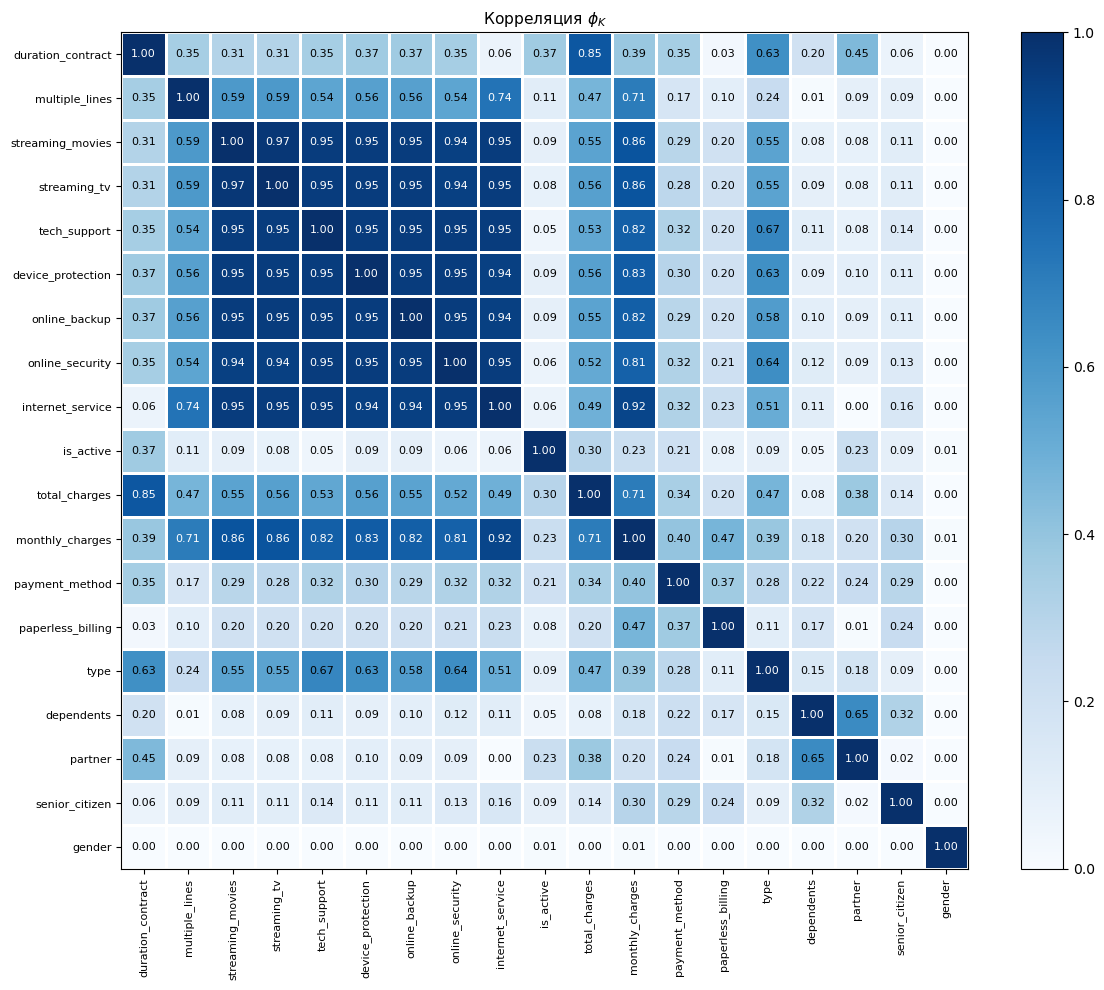

In [45]:
plot_correlation_matrix(
    col_matrix.round(2).values, 
    x_labels=col_matrix.columns, 
    y_labels=col_matrix.index, 
    vmin=0, 
    vmax=1, 
    color_map='Blues', 
    title=r'Корреляция $\phi_K$', 
    fontsize_factor=0.8, 
    figsize=(12, 10)
)
plt.tight_layout()
plt.show()

Очень мало признаков имееют хоть какую-то зависимость с целевой переменной, если установить порог зависимости `0.30`, то в итоговый набор данных войдут всего лишь 2 признака. При этом признки из таблицы `internet` сильно коррелируют между собой.

Оставим признаки, которые имеют корреляцию с целевым признаком 0.08 и выше, а так же те признаки, которые имеют межпризнаковую корреляцию нмже 0.75:
- `duration_contract`
- `partner`
- `payment_method`
- `multiple_lines`
- `online_backup`
- `type`
- `senior_citizen`
- `paperless_billing`

Построим итоговую матрицу корреляции

In [46]:
list_hight_cor = [
    'is_active',
    'duration_contract',
    'partner',
    'payment_method',
    'multiple_lines',
    'online_backup',
    'type',
    'senior_citizen',
    'paperless_billing'
]

In [47]:
dop_col_matrix = df[list_hight_cor].phik_matrix(
    interval_cols=[ 
        'duration_contract'
    ]
)

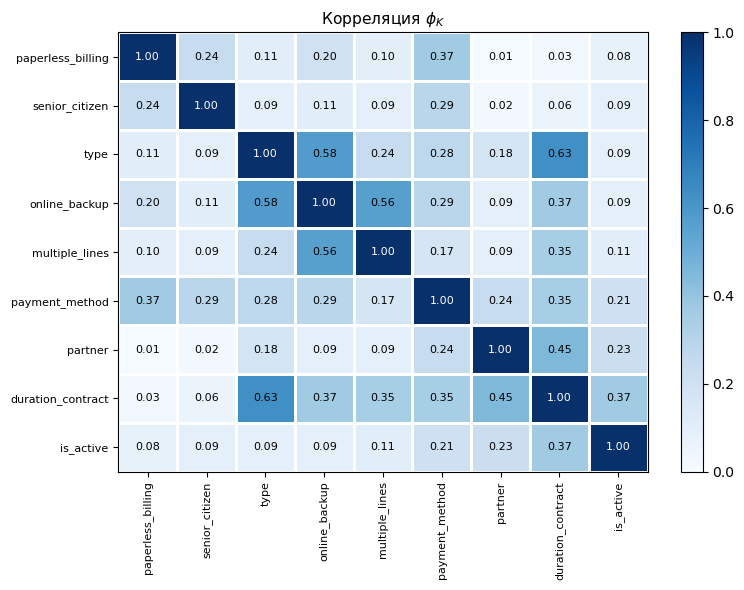

In [48]:
plot_correlation_matrix(
    dop_col_matrix.round(2).values, 
    x_labels=dop_col_matrix.columns, 
    y_labels=dop_col_matrix.index, 
    vmin=0, 
    vmax=1, 
    color_map='Blues', 
    title=r'Корреляция $\phi_K$', 
    fontsize_factor=0.8, 
    figsize=(8, 6)
)
plt.tight_layout()
plt.show()

#### Целевой признак

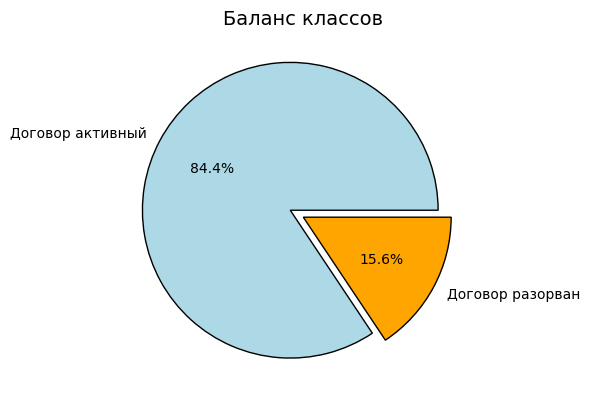

In [49]:
plt.title('Баланс классов', fontsize=14)
plt.pie(
    df.is_active.value_counts(),
    labels = ['Договор активный', 'Договор разорван'],
    explode = [0.1, 0],
    colors = ['lightblue', 'orange'],
    wedgeprops={'lw':1, 'ls':'-', 'edgecolor':'k'},
    autopct='%1.1f%%'
);

В данных присутствует сильный дисбаланс классов, активных договоров почти в 5 раз больше, чем разорванных.

#### Количественные признаки

In [50]:
def get_hist(column, title, xlabel):
    plt.figure(figsize=(6,4))
    plt.hist(df.loc[df.is_active == 1, column], bins=100)
    plt.hist(df.loc[df.is_active == 0, column], bins=100)
    plt.legend(['Договор активный', 'Договор разорван'])
    plt.grid(True)
    plt.title(title, fontsize=TITLE_FONTSIZE, pad=TITLE_PAD)
    plt.xlabel(xlabel, fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD)
    plt.ylabel('Кол-во объектов', fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD);

In [51]:
df.duration_contract.describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration_contract, dtype: float64

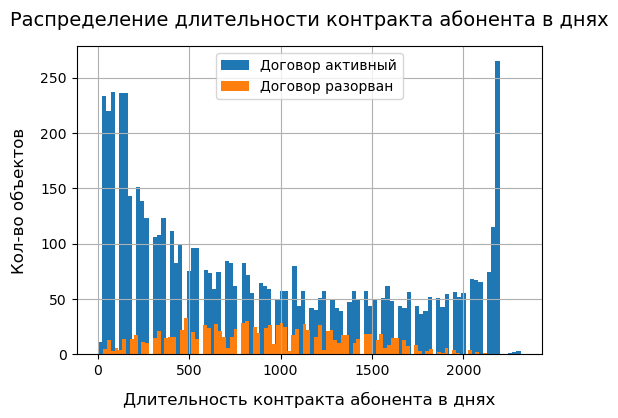

In [52]:
get_hist(
    'duration_contract', 
    'Распределение длительности контракта абонента в днях', 
    'Длительность контракта абонента в днях'
)

Распределение длительности контракта активных договоров имеет пики в начале и в конце, распределение разорваных договоров похоже на низкий колокол, большинство разорваных договоров приходится по длительности на значения около 500 и 1000 дней. 

#### Категориальные признаки

In [53]:
def get_bar(column, title, xlabel=''):
    df_is_active_0 = df[df.is_active == 0].groupby([column]).agg({column: 'count'})
    df_is_active_1 = df[df.is_active == 1].groupby([column]).agg({column: 'count'})
    
    plt.figure(figsize=(6,4))
    plt.bar(df_is_active_1.index, df_is_active_1[column])
    plt.bar(df_is_active_0.index, df_is_active_0[column])
    plt.grid(True)
    plt.legend(['Договор активный', 'Договор разорван'], fontsize='small')
    plt.title(title, fontsize=TITLE_FONTSIZE, pad=TITLE_PAD)
    plt.xlabel(xlabel, fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD);
    plt.ylabel('Кол-во объектов', fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD)

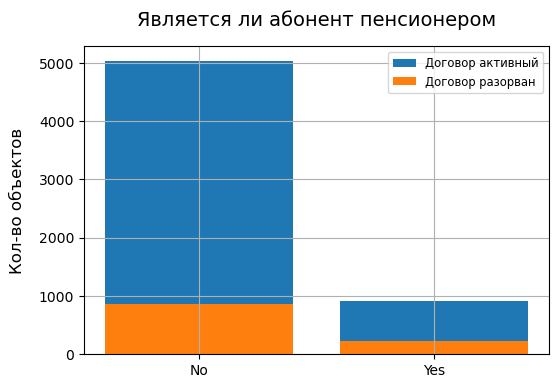

In [54]:
get_bar(
    'senior_citizen', 
    'Является ли абонент пенсионером'
)

Большинство клиентов не являются пенсионерами, как в активных договорах, так и в разорваных

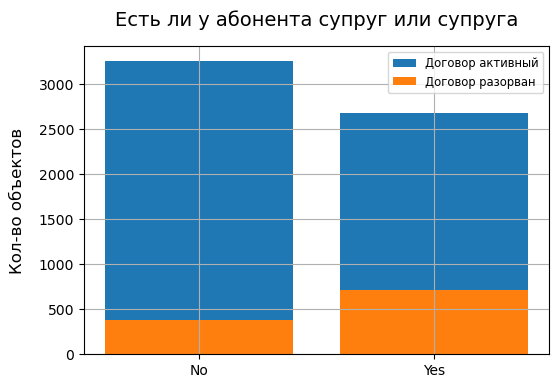

In [55]:
get_bar(
    'partner', 
    'Есть ли у абонента супруг или супруга'
)

Среди клиентов, имеющих активный договор, больше неженатых и незамужних, а среди тех, кто разорвал договор, - наоборот - больше женатых и замужних.

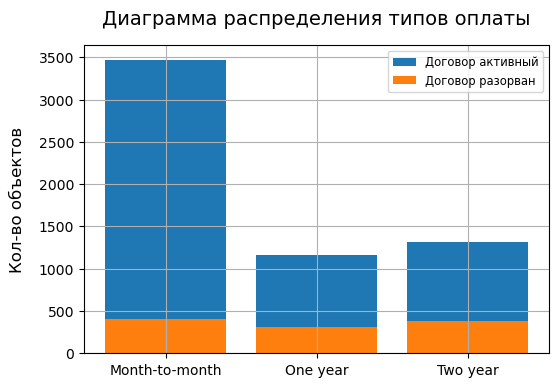

In [56]:
get_bar(
    'type', 
    'Диаграмма распределения типов оплаты'
)

Больше всего абоненты предпочитают оплачивать услуги от месяца к месяцу, при этом доля разорвавших договор среди тех, кто оплачивает раз в год или два года, больше чем среди тех, кто платит помесячно.

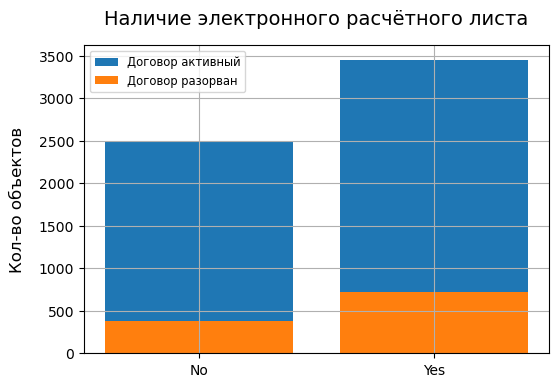

In [57]:
get_bar(
    'paperless_billing', 
    'Наличие электронного расчётного листа'
)

У большинства клиентов, как с активным договором, так и с закрытым, есть электронный расчетный лист.

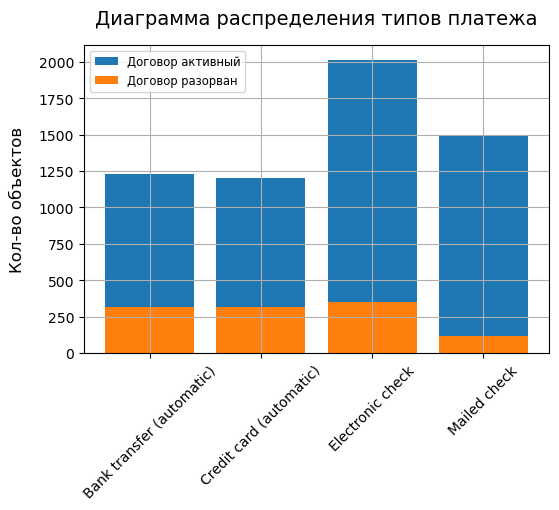

In [58]:
get_bar(
    'payment_method', 
    'Диаграмма распределения типов платежа'
)
plt.xticks(rotation=45);

Среди абонентов больше тех, кто расплачивается с электронным чеком, при этом доля разорвавших договор среди тех, кто оплачивает автоматически, больше.

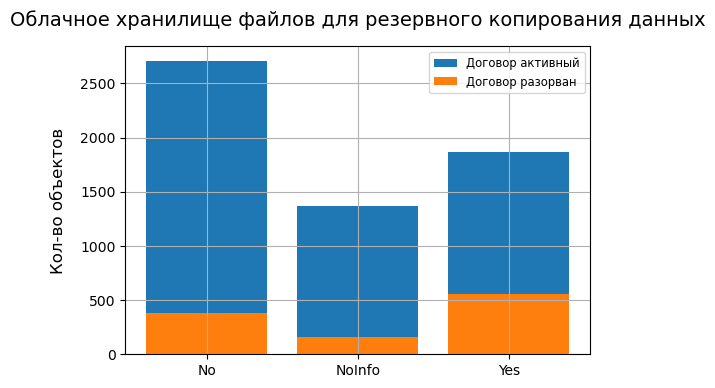

In [59]:
get_bar(
    'online_backup', 
    'Облачное хранилище файлов для резервного копирования данных'
)

У большинства клиентов активных договоров нет облачного хранилища файлов для резервного копирования данных. При этом доля клиентов разорвавших договоров среди тех, у кого есть хранилище, больше, чем среди тех, у кого нет.

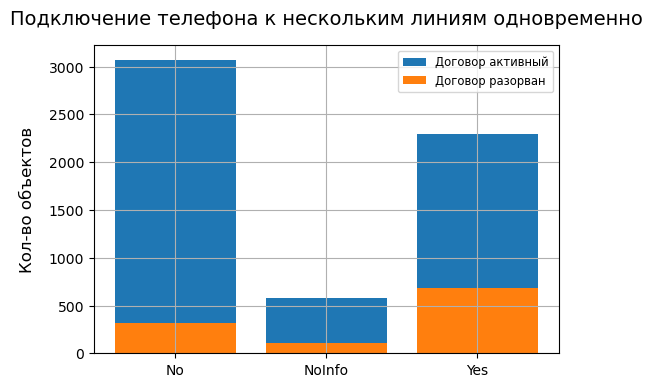

In [60]:
get_bar(
    'multiple_lines', 
    'Подключение телефона к нескольким линиям одновременно'
)

Большинство клиентов активных договоров не использует подключение телефона к нескольким линиям одновременно, большинство разорвавших договор - использует. Доля клиентов разорвавших договор среди тех, кто использует подключение к нескольким линиям, больше, чем среди тех, кто не использует.

### Разделение данных на выборки

In [61]:
num_column = ['duration_contract']

cat_column = [
    'partner',
    'payment_method',
    'multiple_lines',
    'online_backup',
    'type',
    'senior_citizen',
    'paperless_billing'
]

In [62]:
features = df[num_column + cat_column]
target = df.is_active

In [63]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = .25, random_state = RANDOM_STATE, stratify=target
)

In [64]:
print(
    'Размер features_train:', features_train.shape,
    '\nРазмер target_train:', target_train.shape,
    '\nРазмер features_test:', features_test.shape,
    '\nРазмер target_test:', target_test.shape
)

Размер features_train: (5282, 8) 
Размер target_train: (5282,) 
Размер features_test: (1761, 8) 
Размер target_test: (1761,)


### Кодирование и масштабирование данных

In [65]:
col_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_column),
    (StandardScaler(), num_column),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [66]:
features_train = pd.DataFrame(
    col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out()
)

features_train.head()

,partner_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,multiple_lines_NoInfo,multiple_lines_Yes,online_backup_NoInfo,online_backup_Yes,type_One year,type_Two year,senior_citizen_Yes,paperless_billing_Yes,duration_contract
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.343547
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.831537
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.877243
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.100369
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.100369


In [67]:
features_test = pd.DataFrame(
    col_transformer.transform(features_test),
    columns=col_transformer.get_feature_names_out()
)

features_test.head()

,partner_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,multiple_lines_NoInfo,multiple_lines_Yes,online_backup_NoInfo,online_backup_Yes,type_One year,type_Two year,senior_citizen_Yes,paperless_billing_Yes,duration_contract
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.275936
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.745335
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.747210
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.790628
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.278617


### Вывод

**По разделу "Предобработка и исследовательский анализ данных"**

Обзор уникальных значений выявил несколько моментов:

- в столбце `end_date` таблицы `contract` есть строковое значение `No`, скорее всего это означает, что действие договора еще не окончено - заменили такие значения на  дату `2020-02-01` (так как информация о договорах актуальна на 1 февраля 2020);
- значения в столбцах `monthly_charges` и `total_charges` таблицы `contract` строковые, хотя должны быть вещественные - значения-аномалии `' '` в столбце `total_charges` заменили на 0, так как отсутствие числового значения скорее всего связано с отсутствием оплат, далее оба столбца были приведены к типу `float`;
- значения столбца `senior_citizen` таблицы `personal` равны 0 и 1 - не как в других столбцах  `No` и `Yes` соответственно - привели к единому стилю со всеми столбцами.

При соединении таблиц образовались пропуски в столбцах, присоединенных из таблиц с инфориацией об интернете и телефонной связи. Так как люди могут пользоваться и телефоном, и интернетом вместе, могут не пользоваться ничем или чем-то одним, тут сложно угадать что именно скрывается за пропусками, заменили их на значение `NoInfo`.

Далее было создано 2 новые переменные из колонок `begin_date` и `end_date`:
- целевая переменная `is_active`;
- длительность контракта абонента в днях `duration_contract`.

После этого колонки `begin_date` и` end_date` были удалены.

При проверке данных на мультиколлинеарность выяснилось, что очень мало признаков имееют хоть какую-то зависимость с целевой переменной, если установить порог зависимости 0.30, то в итоговый набор данных войдут всего лишь 2 признака. При этом признки из таблицы `internet` сильно коррелируют между собой.

В итоге было решено оставить признаки, которые имеют корреляцию с целевым признаком 0.08 и выше, а так же те признаки, которые имеют межпризнаковую корреляцию нмже 0.75:
- duration_contract
- partner
- payment_method
- multiple_lines
- online_backup
- type
- senior_citizen
- paperless_billing

Во время исследовательского анализа оставшихся данных были выявлены следующие закономерности:
- В данных присутствует сильный дисбаланс классов, активных договоров почти в 5 раз больше, чем разорванных.
- Распределение длительности контракта активных договоров имеет пики в начале и в конце, распределение разорваных договоров похоже на низкий колокол, большинство разорваных договоров приходится по длительности контракта абонента в днях на значения около 500 и 1000 дней.
- Большинство клиентов не являются пенсионерами, как в активных договорах, так и в разорваных
- Среди клиентов, имеющих активный договор, больше неженатых и незамужних, а среди тех, кто разорвал договор, - наоборот - больше женатых и замужних.
- Больше всего абоненты предпочитают оплачивать услуги от месяца к месяцу, при этом доля разорвавших договор среди тех, кто оплачивает раз в год или два года, больше чем среди тех, кто платит помесячно.
- У большинства клиентов, как с активным договором, так и с закрытым, есть электронный расчетный лист.
- Среди абонентов больше тех, кто расплачивается с электронным чеком, при этом доля разорвавших договор среди тех, кто оплачивает автоматически, больше.
- У большинства клиентов активных договоров нет облачного хранилища файлов для резервного копирования данных. При этом доля клиентов разорвавших договоров среди тех, у кого есть хранилище, больше, чем среди тех, у кого нет.
- Большинство клиентов активных договоров не использует подключение телефона к нескольким линиям одновременно, большинство разорвавших договор - использует. Доля клиентов разорвавших договор среди тех, кто использует подключение к нескольким линиям, больше, чем среди тех, кто не использует.

В рамках подготовки к обучению моделей данные были разделены на тренировочную и тестовую выборки в соотношении 0.25, а так же отмасштабированы и кодированы.

## Обучение моделей

По условию задачи необходимо рассмотреть 3 вида моделей:
- решающее дерево или случайный лес;
- бустинги;
- нейронные сети.

При этом качество моделей необходимо оценить на кросс-валидации метрикой `ROC-AUC`.

### RandomForestClassifier

In [68]:
model_RFC = RandomForestClassifier(
    random_state = RANDOM_STATE, 
    class_weight='balanced'
)

params_RFC = {
    'n_estimators':  range(10, 151, 10),
    'max_depth': range(1, 16),
    'min_samples_leaf': range(2, 11),
    'min_samples_split': range(2, 11)
}

In [69]:
rscv_RFC = RandomizedSearchCV(
    model_RFC, 
    params_RFC, 
    scoring='roc_auc', 
    n_iter=20,
    n_jobs=-1, 
    cv=5,
    random_state=RANDOM_STATE
)

In [70]:
rscv_RFC.fit(features_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=12082024),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 16),
                                        'min_samples_leaf': range(2, 11),
                                        'min_samples_split': range(2, 11),
                                        'n_estimators': range(10, 151, 10)},
                   random_state=12082024, scoring='roc_auc')

In [71]:
print('Лучшие параметры:', rscv_RFC.best_params_)
print('Лучший результат:', rscv_RFC.best_score_)

Лучшие параметры: {'n_estimators': 110, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 7}
Лучший результат: 0.8213393873615409


### CatBoostClassifier

In [72]:
model_CBC = CatBoostClassifier(
    random_state=RANDOM_STATE,
    auto_class_weights='Balanced',
    verbose=False
)

params_CBC = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.3),
    'iterations': randint(10, 500)
}

In [73]:
rscv_CBC = RandomizedSearchCV(
    model_CBC, 
    params_CBC, 
    scoring='roc_auc', 
    n_iter=20,
    n_jobs=-1, 
    cv=5,
    random_state=RANDOM_STATE
)

In [74]:
rscv_CBC.fit(features_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x152853cd0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x152853c40>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x152853af0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1528771f0>},
                   random_state=12082024, scoring='roc_auc')

In [75]:
print('Лучшие параметры:', rscv_CBC.best_params_)
print('Лучший результат:', rscv_CBC.best_score_)

Лучшие параметры: {'depth': 4, 'iterations': 268, 'learning_rate': 0.17370635700884346}
Лучший результат: 0.9237055573653932


### NN

In [76]:
X_train = torch.from_numpy(features_train.values).float()
X_test = torch.from_numpy(features_test.values).float()
y_train = torch.unsqueeze(torch.tensor(target_train.values), 1).float()
y_test = torch.unsqueeze(torch.tensor(target_test.values), 1).float()

In [77]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Sigmoid()
        self.reg1 = nn.BatchNorm1d(n_hidden_neurons_1)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Tanh()
        self.reg2 = nn.Dropout(p=0.2)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [78]:
net = Net(X_train.shape[1], 16, 8, 1)

loss = nn.BCELoss()

optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=0.001, 
    betas=(0.9, 0.999),  
    eps=1e-08, 
    weight_decay=0, 
    amsgrad=False
)

In [80]:
def run_baseline(your_net):
    batch_size = 300
    num_epochs = 101
    num_batches = ceil(len(X_train) / batch_size)
    
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train)) # случайная перестановка объектов
                
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            
            optimizer.zero_grad()  # обнулить накопленный градиент
            
            batch_indexes = order[start_index:start_index+batch_size] # получение индексов текущего батча
            features_batch = X_train[batch_indexes]
            target_batch = y_train[batch_indexes]
            
            preds = your_net.forward(features_batch)

            loss_value = loss(preds, target_batch)
            loss_value.backward()  # вычисляется значение градиента функции потерь и выполняется шаг работы оптимизатора (обновление весов в сети)

            optimizer.step()  # Сделать шаг оптимизации
    
    your_net.eval()  # перевод сети в режим предсказания
    preds = your_net.forward(X_train)
    
    return roc_auc_score(np.array(y_train), preds.detach().numpy())

In [81]:
nn_score = run_baseline(net)
print('Результат:', nn_score)

Результат: 0.8275417479927492


### Обзор результатов

In [82]:
result_dict = {
    'RFC': rscv_RFC.best_score_,
    'CBC': rscv_CBC.best_score_,
    'NN': nn_score
}

df_result = pd.DataFrame(
    list(result_dict.items()), columns = ['model', 'ROC-AUC']
)

In [83]:
df_result

,model,ROC-AUC
0,RFC,0.821339
1,CBC,0.923706
2,NN,0.827542


### Вывод

**По разделу "Обучение моделей"**

По условию задачи было рассмотрено 3 вида моделей:

- случайный лес;
- бустинг `catboost`;
- нейронная сеть.

Качество моделей оценивалось на кросс-валидации метрикой `ROC-AUC`.

Все модели справились достаточно хорошо, лучший результат показала модель градиентного бустинга с метрикой `ROC-AUC = 0.92`. Ее будем использовать для тестирования.

## Тестирование модели

In [84]:
target_pred = rscv_CBC.best_estimator_.predict(features_test)

In [86]:
pred_proba = rscv_CBC.best_estimator_.predict_proba(features_test)[:, 1]

In [87]:
print(
    'Результат ROC-AUC на тестовой выборке:',
    round(roc_auc_score(target_test, pred_proba), 4),
    '\nРезультат accuracy на тестовой выборке',
    round(accuracy_score(target_test, target_pred), 4)
)

Результат ROC-AUC на тестовой выборке: 0.9265 
Результат accuracy на тестовой выборке 0.8887


Удалось достичь требуемого значения метрики на тестовой выборке: `ROC-AUC = 0.9265`. Доля правильных ответов тоже довольно высокая: `accuracy = 0.8887`.

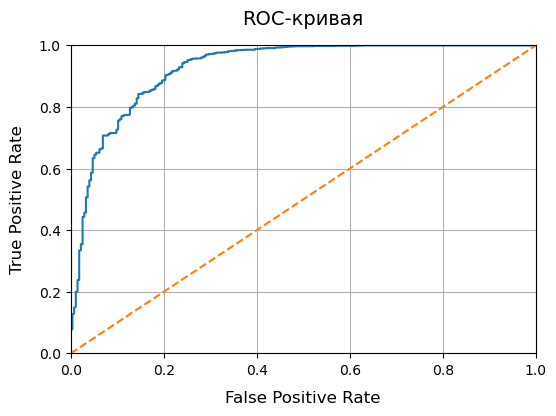

In [88]:
# predicted_probalities = rscv_CBC.best_estimator_.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD)
plt.ylabel('True Positive Rate', fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD)
plt.title('ROC-кривая', fontsize=TITLE_FONTSIZE, pad=TITLE_PAD)

plt.show()

Кривая ROC сильно отличается от диагональной прямой (она соответствует «бесполезному» классификатору, т.е. полной неразличимости двух классов) и находится близко к верхнему левому углу, предсказательная способность модели достаточно высокая.

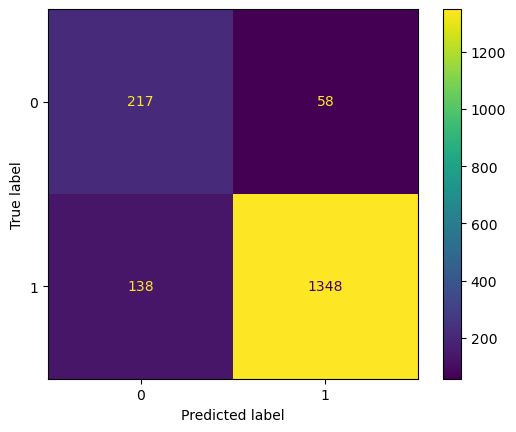

In [89]:
conf_matrix = confusion_matrix(target_test, target_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show();

In [90]:
sum(target_test == 0)

275

In [91]:
sum(target_test == 1)

1486

Модель хорошо предсказывает истинно-положительные и истинно-ложные ответы, большинство ошибок заключается в излишнем предсказании ложно-отрицательных ответов.

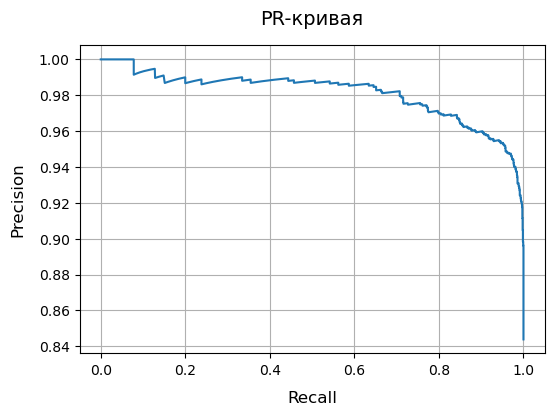

In [92]:
precision, recall, threshold = precision_recall_curve(target_test, pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.grid(True)
plt.xlabel('Recall', fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD)
plt.ylabel('Precision', fontsize=LABLE_FONTSIZE, labelpad=LABELE_PAD)
plt.title('PR-кривая', fontsize=TITLE_FONTSIZE, pad=TITLE_PAD)

plt.show()

Модель имеет достаточно большую площадь под кривой, что говорит о хорошем качестве модели.

In [93]:
df_feature_importances = pd.DataFrame({
    'name_column': features_test.columns.tolist(),
    'value_importance': rscv_CBC.best_estimator_.feature_importances_.tolist()
})

In [94]:
df_feature_importances.sort_values('value_importance', ascending=False)

,name_column,value_importance
12,duration_contract,81.422391
9,type_Two year,3.329714
5,multiple_lines_Yes,2.355481
3,payment_method_Mailed check,1.967299
0,partner_Yes,1.890408
8,type_One year,1.804560
7,online_backup_Yes,1.530264
11,paperless_billing_Yes,1.364546
6,online_backup_NoInfo,1.284393
4,multiple_lines_NoInfo,1.140968


Наиболее важным признаком оказалась длительность контракта абонента в днях - созданный признак.

### Вывод

**По разделу "Тестирование модели"**

На тестовой выборке удалось достичь требуемого значения ROC-AUC = 0.9265. Также доля правильных ответов тоже довольно высокая: accuracy = 0.8887.

Модель хорошо предсказывает истинно-положительные и истинно-ложные ответы, большинство ошибок заключается в излишнем предсказании ложно-отрицательных ответов.

Наиболее важным признаком оказалась длительность контракта абонента в днях - созданный признак.

В целом модель неплохо справляется со своей задачей.

## Общий вывод

Для прогноза оттока клиентов предоставлены 4 таблицы данных с информацией о договорах, персональных данных клиентов, интернет-услугах и услугах телефонии. 

Все таблицы содержат данные, количество таблиц соответствует условию задачи.

- Таблица `contract` состоит из 8 колонок и 7043 строк
- Таблица `personal` состоит из 5 колонок и 7043 строк
- Таблица `internet` состоит из 8 колонок и 5517 строк
- Таблица `phone` состоит из 2 колонок и 6361 строки

Все таблицы можно соединить, используя идентификатор пользователя.

Так же в полученных данных отсутствовали явные пропуски и дубликаты.

Обзор уникальных значений выявил несколько моментов:
- в столбце `end_date` таблицы `contract` есть строковое значение `No`, скорее всего это означает, что действие договора еще не окончено - заменили такие значения на  дату `2020-02-01` (так как информация о договорах актуальна на 1 февраля 2020);
- значения в столбцах `monthly_charges` и `total_charges` таблицы `contract` строковые, хотя должны быть вещественные - значения-аномалии `' '` в столбце `total_charges` заменили на 0, так как отсутствие числового значения скорее всего связано с отсутствием оплат, далее оба столбца были приведены к типу `float`;
- значения столбца `senior_citizen` таблицы `personal` равны 0 и 1 - не как в других столбцах  `No` и `Yes` соответственно - привели к единому стилю со всеми столбцами.

При соединении таблиц образовались пропуски в столбцах, присоединенных из таблиц с инфориацией об интернете и телефонной связи. Так как люди могут пользоваться и телефоном, и интернетом вместе, могут не пользоваться ничем или чем-то одним, тут сложно угадать что именно скрывается за пропусками, заменили их на значение `NoInfo`.

Далее было создано 2 новые переменные из колонок `begin_date` и `end_date`:
- целевая переменная `is_active`;
- длительность контракта абонента в днях `duration_contract`.

После этого колонки `begin_date` и` end_date` были удалены.

При проверке данных на мультиколлинеарность выяснилось, что очень мало признаков имееют хоть какую-то зависимость с целевой переменной, если установить порог зависимости 0.30, то в итоговый набор данных войдут всего лишь 2 признака. При этом признки из таблицы `internet` сильно коррелируют между собой.

В итоге было решено оставить признаки, которые имеют корреляцию с целевым признаком 0.08 и выше, а так же те признаки, которые имеют межпризнаковую корреляцию нмже 0.75:
- duration_contract
- partner
- payment_method
- multiple_lines
- online_backup
- type
- senior_citizen
- paperless_billing

Во время исследовательского анализа оставшихся данных были выявлены следующие закономерности:
- В данных присутствует сильный дисбаланс классов, активных договоров почти в 5 раз больше, чем разорванных.
- Распределение длительности контракта активных договоров имеет пики в начале и в конце, распределение разорваных договоров похоже на низкий колокол, большинство разорваных договоров приходится по длительности контракта абонента в днях на значения около 500 и 1000 дней.
- Большинство клиентов не являются пенсионерами, как в активных договорах, так и в разорваных
- Среди клиентов, имеющих активный договор, больше неженатых и незамужних, а среди тех, кто разорвал договор, - наоборот - больше женатых и замужних.
- Больше всего абоненты предпочитают оплачивать услуги от месяца к месяцу, при этом доля разорвавших договор среди тех, кто оплачивает раз в год или два года, больше чем среди тех, кто платит помесячно.
- У большинства клиентов, как с активным договором, так и с закрытым, есть электронный расчетный лист.
- Среди абонентов больше тех, кто расплачивается с электронным чеком, при этом доля разорвавших договор среди тех, кто оплачивает автоматически, больше.
- У большинства клиентов активных договоров нет облачного хранилища файлов для резервного копирования данных. При этом доля клиентов разорвавших договоров среди тех, у кого есть хранилище, больше, чем среди тех, у кого нет.
- Большинство клиентов активных договоров не использует подключение телефона к нескольким линиям одновременно, большинство разорвавших договор - использует. Доля клиентов разорвавших договор среди тех, кто использует подключение к нескольким линиям, больше, чем среди тех, кто не использует.

В рамках подготовки к обучению моделей данные были разделены на тренировочную и тестовую выборки в соотношении 0.25, а так же отмасштабированы и кодированы.

По условию задачи было рассмотрено 3 вида моделей:

- случайный лес;
- бустинг `catboost`;
- нейронная сеть.

Качество моделей оценивалось на кросс-валидации метрикой `ROC-AUC`.

Все модели справились достаточно хорошо, лучший результат показала модель градиентного бустинга с метрикой `ROC-AUC = 0.92`. Ее использовали для тестирования.

На тестовой выборке удалось достичь требуемого значения ROC-AUC = 0.9265. Также доля правильных ответов тоже довольно высокая: accuracy = 0.8887.

Модель хорошо предсказывает истинно-положительные и истинно-ложные ответы, большинство ошибок заключается в излишнем предсказании ложно-отрицательных ответов.

Наиболее важным признаком оказалась длительность контракта абонента в днях - созданный признак.

В целом модель неплохо справляется со своей задачей.

Для улучшения работы модели можно рассмотреть следующие моменты:
- собрать больше данных и обучить модель на них;
- рассмотреть внедрение новых признаков, возможно не все учитывается во время сбора данных о клиентах;
- ввести корпоративную метрику качества, "бизнес-метрику", например финансовый ущерб от ухода клиента;
- оптимизировать хранение данных на основе выявленных проблем.